# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Integration

In [ ]:
df_temp = pd.read_csv('/content/drive/MyDrive/SEM 7/IMD-TP Load Forecast/Updated Yearly Data/allyearstemp.csv')
df_temp

,Temp
0,18.160
1,18.064
2,17.927
3,17.745
4,17.751
...,...
195548,27.740
195549,27.660
195550,27.620
195551,27.640


In [ ]:
df_all = pd.concat(df.values(), ignore_index=True)
df_all.shape

TypeError: ignored

# Data Cleaning

In [ ]:
df_all = df_all.set_index('DateTime')

In [ ]:
df_temp = df_all.drop(['Load', 'RH'], axis=1)

In [ ]:
df_temp.head()

,Temp
0,18.160
1,18.064
2,17.927
3,17.745
4,17.751


# EDA

<Axes: xlabel='DateTime'>

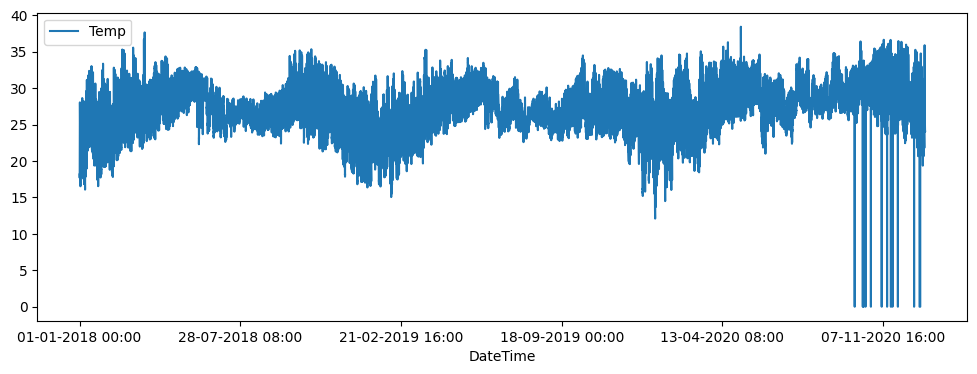

In [ ]:
df_temp.plot(figsize=(12, 4))

In [ ]:
len(df_temp)

195553

In [ ]:
np_temp = df_temp.to_numpy()
np_temp

array([[18.16 ],
       [18.064],
       [17.927],
       ...,
       [27.62 ],
       [27.64 ],
       [27.66 ]])

In [ ]:
np_temp.shape

(195553, 1)

In [ ]:
np_temp.dtype

dtype('float64')

# Scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
np_temp_scaled = scaler.fit_transform(np_temp)

In [ ]:
np_temp_scaled.shape

(195553, 1)

In [ ]:
np_temp_scaled = np_temp_scaled.astype('float32')
np_temp_scaled.dtype

dtype('float32')

# Data Preparation

In [ ]:
def prepare_data(np_temp_scaled, n_input):
  X, y = [], []
  for i in range(len(np_temp_scaled)-n_input):
    window = i + n_input
    step = 192 + window
    if window>len(np_temp_scaled)-192:
      break
    else:
      seq_x, seq_y = np_temp_scaled[i:window], np_temp_scaled[window:step]
      X.append(seq_x)
      y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
n_input = 672
n_features = 1
X, y = prepare_data(np_temp_scaled, n_input)

In [ ]:
X.dtype, y.dtype

(dtype('float32'), dtype('float32'))

In [ ]:
X.shape, y.shape

((194690, 672, 1), (194690, 192, 1))

# Data Splitting

In [ ]:
split_index = int(0.80 * len(X))  # 80% for training, 20% for testing
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

In [ ]:
X_train.shape, y_train.shape

((155752, 672, 1), (155752, 192, 1))

In [ ]:
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
y_val = y_val.reshape(y_val.shape[0], y_val.shape[1])
y_train.shape

(155752, 192)

# Optuna

In [ ]:
# import optuna

# def create_model(trial):

#   # Create the LSTM model
#   model = Sequential()
#   model.add(LSTM(units=(trial.suggest_int('lstm_1_units', y_train.shape[1], X_train.shape[1])), activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#   # model.add(LSTM(units=(trial.suggest_int('lstm_2_units', y_train.shape[1], X_train.shape[1])), activation='tanh', return_sequences=True))
#   model.add(LSTM(units=(trial.suggest_int('lstm_3_units', y_train.shape[1], X_train.shape[1])), activation='tanh'))
#   model.add(Dense(y_train.shape[1]))

#   # Compile the model
#   optimizer_name = trial.suggest_categorical("optimizer", ["adam", "SGD", "RMSprop", "Adadelta"])
#   model.compile(optimizer=optimizer_name, loss="mse")
#   return model

# def objective(trial):
#   model = create_model(trial)
#   epochs = trial.suggest_int("epochs", 5, 50, step=5, log=False)
#   batchsize = trial.suggest_int("batchsize", 50, 100, step=5, log=False)

#   # Train the model
#   model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs)

#   # Evaluate the model
#   scores = model.evaluate(X_val, y_val, verbose=0)
#   return scores[1]

# study = optuna.create_study()
# study.optimize(objective, n_trials=5)

# print(study.best_params)

# Model Building

In [ ]:
model = Sequential()
model.add(LSTM(256, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(192))
model.compile(optimizer='adam', loss='mse')
model.summary()
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 672, 256)          264192    
                                                                 
 lstm_1 (LSTM)               (None, 672, 128)          197120    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 192)               12480     
                                                                 
Total params: 523200 (2.00 MB)
Trainable params: 523200 (2.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
3894/3894 [==============================] - 328s 82ms/step - loss: 0.0037 - val_loss: 0.0103
Epoch 2/10
3894/3894 [=========================

# Training Loss v/s Validation Loss

In [ ]:
loss = model.evaluate(X_val, y_val)
print("Test loss:", loss)

1217/1217 [==============================] - 45s 37ms/step - loss: 0.0294
Test loss: 0.029357818886637688


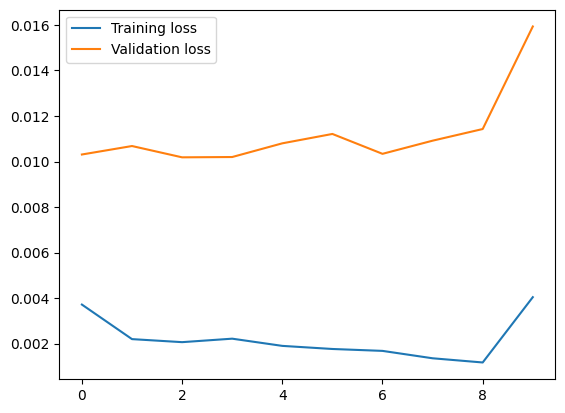

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

# Model Save

In [ ]:
model.save('/content/drive/MyDrive/IMD-TP Load Forecast/Final Models/LSTM/Temp_allyrs_v1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Predictions

In [ ]:
# from keras.models import load_model
# model = load_model('/content/drive/MyDrive/IMD-TP Load Forecast/LSTM/Temp_181920_v1.h5')
pred = model.predict(X_val)
pred

1217/1217 [==============================] - 38s 31ms/step


array([[0.54089576, 0.540323  , 0.5404066 , ..., 0.532985  , 0.53126824,
        0.53102314],
       [0.54204035, 0.5414545 , 0.54150224, ..., 0.5340572 , 0.5323478 ,
        0.5320668 ],
       [0.54244435, 0.54179573, 0.541849  , ..., 0.53441083, 0.53270674,
        0.53238654],
       ...,
       [0.5227779 , 0.52197826, 0.5226749 , ..., 0.51565945, 0.51392376,
        0.5139973 ],
       [0.5222134 , 0.5217472 , 0.52240974, ..., 0.515496  , 0.5136662 ,
        0.5139427 ],
       [0.51905626, 0.51829946, 0.5190901 , ..., 0.5122767 , 0.51049525,
        0.5106752 ]], dtype=float32)

# Performance Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import pearsonr

def perf_eval(y_val, pred):
  rmse = np.sqrt(mean_squared_error(y_val, pred))
  kpcc = pearsonr(pred.flatten(), y_val.flatten())
  print(f'RMSE: {rmse}\nKPCC: {kpcc}')

In [ ]:
perf_eval(y_val, pred)

RMSE: 0.17134013772010803
KPCC: PearsonRResult(statistic=0.4769536191850641, pvalue=0.0)


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_val, pred)
print("Mean Absolute Percentage Error (MAPE):", mape)

Mean Absolute Percentage Error (MAPE): 17.99451857805252


# Final Output

In [ ]:
final_pred = scaler.inverse_transform(pred) #Inverse Scaling
final_pred

array([[28.24762 , 28.12861 , 28.067581, ..., 28.192907, 28.10566 ,
        27.95767 ],
       [28.160595, 28.04852 , 27.996017, ..., 28.079967, 28.000463,
        27.8556  ],
       [28.095324, 27.989117, 27.943743, ..., 27.985125, 27.9133  ,
        27.77338 ],
       ...,
       [20.09673 , 20.156364, 20.230425, ..., 20.689167, 20.61849 ,
        20.499525],
       [20.11489 , 20.21878 , 20.343477, ..., 20.577215, 20.537476,
        20.467232],
       [20.14878 , 20.299862, 20.478374, ..., 20.46775 , 20.462803,
        20.449095]], dtype=float32)

In [ ]:
day1 = final_pred[:96]
day2 = final_pred[96:192]